In [1]:
import numpy  as np
import glob 
import gc 
from   pathlib import Path
from   typing import  List, Tuple, Callable  
from   dataclasses import dataclass, asdict
from   pprint import pprint
from   functools import reduce

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

# import modin.pandas as pd 
# import ray 
# os.environ["MODIN_ENGINE"] = "ray"
# ray.init(ignore_reinit_error=True)
import pandas as pd 

import wandb
print(f'wandb version: {wandb.__version__}')
%env "WANDB_NOTEBOOK_NAME" "m5-eda"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb version: 0.10.30
env: "WANDB_NOTEBOOK_NAME"="m5-eda"
wandb: Currently logged in as: akamlani (use `wandb login --relogin` to force relogin)


True

In [2]:
from    utils.config import load_config

from    flexassist.core.datasets.tabular.info import InfoTabular
import  flexassist.core.datasets.tabular.transform as trsfrm
import  flexassist.core.system.writer                 as wr 

# Problem Scope
- Data: based on heirarchical sales in states (CA, TX, WI
- Forecast Walmart Pricing Sales: (F1-F28) for future 28 days (4 weeks) of items sold for each row
    - Shape should be (x, 28)
    - Use last 28 days for validation
    - For Validation: d_1914 - d_1941 
    - For Evaluation: d_1942 - d_1969 
    - Validation Phase (March 2nd 2020, May 31rst 2020), Actual Values(June 1rst, June 30th)
- Level Attribute Aggregation: (Item, Department, Product, State), Decide how to forecast, e.g. 
    - Unit Sales of all products, aggregated for all stores/states (1)
    - Unit Sales of all products, aggregated for each state (3)
    - Unit Sales of all products, aggregated for each store (10)
    - Unit Sales of all products, aggregated for each category (3)
    - Unit Sales of all products, aggregated for each department (7)
    - Unit Sales of all products, aggregated for each (State, Category) (9)
    - Unit Sales of all products, aggregated for each (State, Dept) (21)
    - Unit Sales of all products, aggregated for each (Store, Category) (30)
    - Unit Sales of all products, aggregated for each (Store, Dept) (70)
    - Unit Sales of product (x),  aggregated for all stores/states (3049)
    - Unit Sales of product (x),  aggregated for each State (9147)
    - Unit Sales of product (x),  aggregated for each Store (30490)
- Extraneous Variables: Prices, Promotions, DateTime/Holidays
- Prediction Intervals and Quantiles: [Reference](https://www.kaggle.com/olafko/m5-uncertainty-prediction-lstm-nn-feature-embedd)

## Ingestion

In [3]:
np.random.seed(42)
config_files:List[str] = glob.glob('./config' + '/*')
config = load_config('./config')
datasets_dir   = Path(config['experiment_parameters']['datasets_dir'])
transforms_dir = Path(datasets_dir)/'transformers'

In [4]:
datasets_dir   = Path(config['experiment_parameters']['datasets_dir'])
transform_dir  = Path(datasets_dir)/'transformers'
df_cal         = pd.read_csv(Path(transform_dir)/'calendar.csv', parse_dates=['date'])    
df_prices      = pd.read_csv(Path(transform_dir)/'sell_prices.csv')    
df_train       = pd.read_csv(Path(transform_dir)/'train.csv')             # d_1 - d_1913, d_1 - d_1941
df_train['id'] = df_train.id.str.replace('_evaluation', '')
df_train.shape   

(30490, 1947)

In [5]:
ts_cols       = [col for col in df_train.columns if 'd_' in col]
lvl_cols      = [col for col in df_train.columns if 'd_' not in col]
# no units sold (Q) at each given day: d_1 - d_1913
# no units sold (Q) at each given day: d_1 - d_1941
no_ts_dt_cols = len(ts_cols)
no_lvl_cols   = len(lvl_cols)
no_ts_dt_cols, no_lvl_cols

(1941, 6)

## EDA

### Training Data

In [6]:
statistics:dict = dict()
# describe training data
num_leading_cols = 6 
infotab     = InfoTabular(df_train)
infotab.describe(df_train, k=num_leading_cols)
# schema
schema      = dict(schema = df_train.dtypes.to_dict())
partition   = dict(shapes = dict(train = df_train.shape))
# missing data
df_train_na = infotab.get_missing_stats(df_train).T
missing_na  = dict(na_missing = df_train_na.to_dict())
# add to metadata about dataset
dataset_metadata = dict(partition)

DataFrame Shape: (30490, 1947)
Columns:         ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']


In [7]:
# unpivot from wide to long format and enrich with other provided datasets
df_sales_qty    = pd.melt(df_train, id_vars=lvl_cols, var_name='day', value_name='sales_qty')
df_sales_qty_dt = df_sales_qty.merge(df_cal, left_on='day', right_on='d')
df_train_comb   = df_sales_qty_dt.merge(df_prices,on=['store_id','item_id', 'wm_yr_wk'], how='left')
# save transformed data to disk
wr.write_csv(df_train_comb, transforms_dir, 'training_fullset.csv')    
# remove memory
del df_sales_qty
del df_sales_qty_dt
gc.collect()

0

In [8]:
# STATE_ID (3):  CA, TX, WI
# STORE_ID (10): CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3
# CAT_ID   (3):  'HOBBIES', 'HOUSEHOLD', 'FOODS'
# DEPT_ID  (7):  'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'
# ITEM_ID  (x):  # {dept_id}_{item_id_value}
# ID:            {item_id}_{store_id}_validation
def get_inventory(df:pd.DataFrame) -> pd.Series:
    "extract information regarding inventory of dataset"
    # extract information from item_id col
    item_cols     = ['category', 'dept', 'item'] 
    df_items      = df.item_id.str.split("_", n = 2, expand = True)
    df_items      = df_items.rename(columns=dict(zip(range(len(item_cols)), item_cols)))
    # build up catalogue count information
    df_catalogue  = df[['id', 'state_id', 'store_id', 'cat_id', 'dept_id']].nunique()
    df_catalogue['global_item_id']   = df['item_id'].nunique()    # globally unique
    df_catalogue['dept_item_id']     = df_items['item'].nunique() # across each department
    df_catalogue                     = pd.DataFrame(df_catalogue).T
    df_catalogue.index               = ['count']
    return df_catalogue

# TBD: find annual 1 year means across each
df_inventory = get_inventory(df_train)
dataset_metadata.update(df_inventory.to_dict())
df_inventory

,id,state_id,store_id,cat_id,dept_id,global_item_id,dept_item_id
count,30490,3,10,3,7,3049,824


In [9]:
# outliers, peaks in terms of zero sales
def get_outliers(df:pd.DataFrame) -> Tuple[pd.Series, List[str], str]:
    "outliers are those with peaks of (0) sales, should return columnar names of form {d_}"
    import scipy.signal as scs
    # peak days should contain columns of {d_}
    xs         = np.count_nonzero(df==0, axis=0)
    peaks, _   = scs.find_peaks(xs, height=np.quantile(xs,0.75), threshold=max(xs)/25)
    peak_days  = df.columns[peaks]
    return xs, peaks, peak_days

def trsfrm_is_holiday(df_dt:pd.DataFrame, indices:List[str]) -> pd.DataFrame:
    # extract particular holidays over time span
    from   pandas.tseries.holiday import USFederalHolidayCalendar as calendar
    start_date, end_date  = (df_dt['date'].min(), df_dt['date'].max())
    holidays              = calendar().holidays(start=start_date, end=end_date)
    # find the indices that were marked as outliers
    df_ind                = df_dt[df_dt['d'].isin(indices)].copy()
    df_ind['is_holiday']  = ((df_ind['event_type_1'] == 'National') | (df_ind['event_type_2'] == 'National')).astype(int)
    return df_ind

# find zero-quanity based transactions, which happen to be holidays
_, _, outlier_cols   = get_outliers(df_train)
df_cal_holidays      = trsfrm_is_holiday(df_cal, outlier_cols)
# remove rows with these outliers columns
outlier_cols         = df_cal_holidays[df_cal_holidays.is_holiday == 1]['d'].tolist()

### Calendar Data

In [10]:
# calendar data 
infotab    = InfoTabular(df_cal)
infotab.describe(df_cal)
# missing values
# impute missing information event information (e.g. holidays)
df_cal_na   = infotab.get_missing_stats(df_cal).T
missing_na  = dict(na_missing = df_cal_na.to_dict())
# dt / time span information, fcst_period represents (lag size)
df_timespan = infotab.describe_dt(df_cal.date, 'train').T
timespan    = dict(timespan = df_timespan.T.to_dict())
# SNAP: Supplement Nutrition Assistance Program (GOV provides for low income families and individuals to purchase food traffic)
# SNAP: Equivalent to food stamps on given date for each State
# ['snap_CA', 'snap_TX', 'snap_WI']

# pd.DataFrame(pd.concat([df_cal[col].value_counts() for col in ['snap_CA', 'snap_TX', 'snap_WI']])).T
# Special Events(event_name_x, event_name_type_y)

DataFrame Shape: (1969, 14)
Columns:         ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']


In [11]:
# update metadata
dataset_metadata.update(timespan)

### Pricing Data

In [12]:
# sales data 
infotab  = InfoTabular(df_prices)
infotab.describe(df_prices)
# price: The price of the product for the given week/store (weekly average across (Store, Item))

DataFrame Shape: (6841121, 4)
Columns:         ['store_id', 'item_id', 'wm_yr_wk', 'sell_price']


## Figures

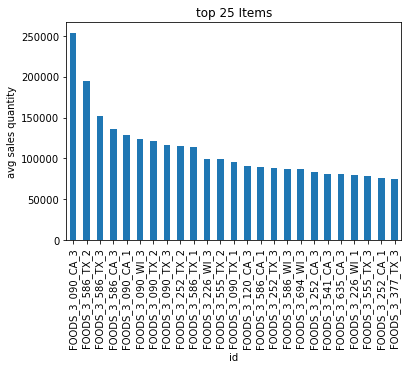

In [13]:
# find the top 25 items that sold the most quantity
k = 25
df_top_ids = df_train.groupby(['id']).mean().T
df_top_ids = df_top_ids.sum().sort_values(ascending=False)[:k]
ax = df_top_ids.plot(kind='bar')
ax.set_title(f'top {k} Items')
ax.set_ylabel('avg sales quantity')
# using these indexes 
df_indices = pd.DataFrame(df_train[df_train['id'].isin(df_top_ids.index)].index, columns=['indice'])
wr.write_csv(df_indices, transforms_dir, 'top_id_indices.csv')   
fig1 = plt.gcf()

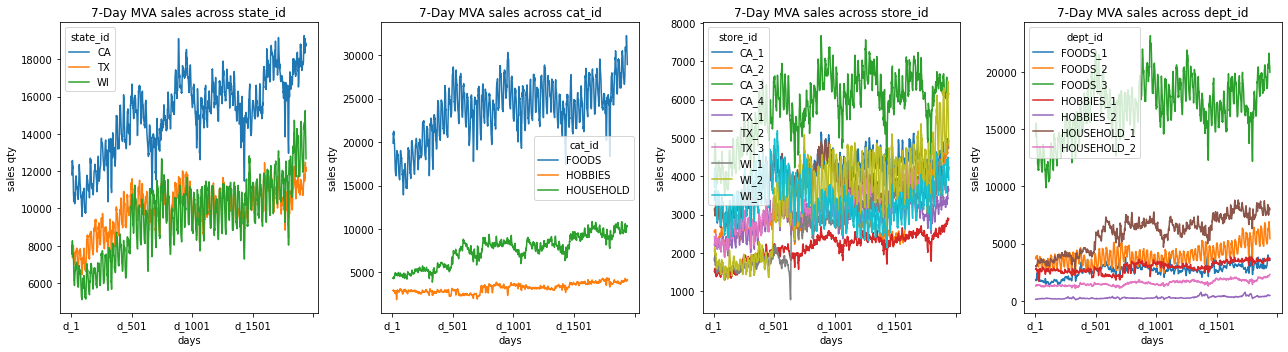

In [14]:
def plot_distributions(df:pd.DataFrame, agg_cols:List[str], period:int=7):
    fig, axes = plt.subplots(1, len(agg_cols), figsize=(18,5))
    for col, axi in zip(agg_cols, axes):
        ds_daily_sales = df[[col] + ts_cols].groupby(col).sum()
        ds_daily_sales.T.rolling(window=period).mean().plot(ax=axi)
        axi.set_title(f'{period}-Day MVA sales across {col}')
        axi.set_xlabel('days')
        axi.set_ylabel('sales qty')
    plt.tight_layout()
    return fig 

# TBD: Add 'Yearly' Mean Vertical Bars
sel_cols  = ['state_id', 'cat_id', 'store_id', 'dept_id']
fig2       = plot_distributions(df_train, sel_cols)

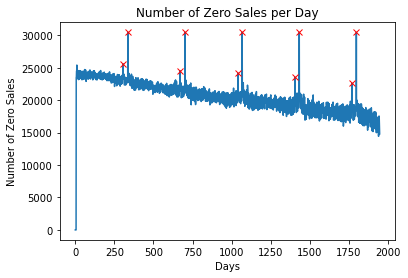

In [15]:
def plot_outliers(df:pd.DataFrame, axi):
    xs, peaks, peak_days = get_outliers(df)
    axi.plot(xs)
    axi.plot(peaks, xs[peaks], "x", color='red')
    axi.set_title('Number of Zero Sales per Day')
    axi.set_ylabel('Number of Zero Sales')
    axi.set_xlabel('Days')
    return plt.gcf() 

fig3  = plot_outliers(df_train, plt.gca())

## Lifecycle Management
- Config Files (Directory)
- Training Data (Directory)
- Analysis

In [16]:
import flexassist.integrations.wandb.lifecycle as lc 
# set up defaults for main lifefycle runner
project = config['project']
tracker     = lc.JobTrackInfo(**dict(
    name    = 'ingestion', 
    project = project['name'], 
    entity  = project['entity'], 
    group   = ":".join(['exp', 'eda']),
    # default main configuration used which will be added to 
    config  = config, 
    tags    = project['tags'] + ['dataset'],
    notes   = "service execution of assets prior to analysis"
))
tracker.format_job_type(cycle=lc.JobTrackingCycle.Ingestion, action=lc.ActionType.Upload)

In [17]:
# setup services
with lc.LifeCycleSvc.execute(tracker) as cxt: 
    artifact_svc    = lc.LifeCycleArtifactSvc()
    for repo_name, type_req, uri_src, uri_dst in zip (
        ['config_repo', 'datasets_repo'], 
        [lc.ArtifactStorage.Config, lc.ArtifactStorage.Dataset],
        ['./config/',    './data/'], 
        ['settings',    'training']):
        # Artifact Add Config Files (./add_dir) to artifact
        artifact_config = lc.ArtifactInfo( **dict( 
            name        = repo_name, 
            type        = lc.ArtifactStorage.Config, 
            description = f"{repo_name} files associated with dataset: {config['dataset']['id']}"
        ))
        # define artifact request
        artifact_svc.add(cxt, artifact_config, uri_src_path = uri_src, uri_dst_path = uri_dst, 
            alias         = ['master', 'baseline'], 
            write_request = lc.ArtifactWrite.AddDir
        )

wandb: Adding directory to artifact (./config)... Done. 0.0s
wandb: Adding directory to artifact (./data)... Done. 0.4s


In [18]:
tracker_analysis = lc.JobTrackInfo(**dict(
    name    = 'analysis', 
    project = project['name'], 
    entity  = project['entity'], 
    group   = tracker.group,
    # default main configuration used which will be added to 
    config  = config, 
    tags    = project['tags'] + ['analyzer', 'transforms'],
    notes   = "service execution of quantitative analysis"
))
tracker_analysis.format_job_type(cycle=lc.JobTrackingCycle.Analysis, action=lc.ActionType.Upload)
with lc.LifeCycleSvc.execute(tracker_analysis) as cxt: 
    artifact_svc    = lc.LifeCycleArtifactSvc()
    # add tables and images to run 
    wandb.log({"inventory distributions":   wandb.Table(dataframe=df_inventory)}, commit=False)
    wandb.log({"top product demand items":  wandb.Image(fig1,  caption='inventory top demand items')}, commit=False)
    wandb.log({"distributions":             wandb.Image(fig2,  caption='inventory distributions')}, commit=False)
    wandb.log({"zero sales":                wandb.Image(fig3,  caption='holiday zero sales')}, commit=True)
    # define transform structure  
    artifact_config = lc.ArtifactInfo( **dict( 
        name        = 'transforms_repo', 
        type        = lc.ArtifactStorage.Transform, 
        description = f"transformation files associated with dataset: {config['dataset']['id']}"
    ))
    # define artifact request
    artifact_svc.add(cxt, artifact_config, uri_src_path = transforms_dir, uri_dst_path = 'transformers', 
        alias         = ['master', 'staging'], 
        write_request = lc.ArtifactWrite.AddDir
    )


wandb: Adding directory to artifact (./experiments/snapshots/m5-fcst-base/exports/artifacts/datasets/transformers)... Done. 11.0s


_runtime,5
_timestamp,1622143411
_step,0


_runtime,▁
_timestamp,▁
_step,▁
